<a href="https://colab.research.google.com/github/DerrickL25/SNN_Gesture_Classification/blob/main/SNN_Tutorial_Derrick_Lee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is an SNN?

An SNN (spiking neural network) is a variation of an ANN. While both types of networks are inspired by the brain, SNNs aim to take advantage of temporal data and mimic the intrinsically discrete nature of biological neurons. In contrast, neurons in ANNs output continuous activation values.
\
SNNs remain a rich research topic, and their applications in the real world are diversifying.
\
\
**Key Differences:**

ANN:
- Neurons take weighted the sum of activation values from previous layer and sends the result into an activation function (most commonly ReLU), returning a new activation value.
- The weighted sum operation is computationally expensive and does not scale well with large network architectures.

SNN:
- Temporal data is fed into the network, creating bursts of activity known as spikes. Neurons fire these spikes when an accumulation function's threshold is met from input activity. These spikes are propagated through the network and reach the output layer like an ANN.
- As neurons can only be 0 or 1, representing their polarity, most tensors propagating through a network are sparse, minimizing the need to perform multiplication, thus greatly reducing the cost of weighted sums.
- Training is more complex, as traditional optimization using backpropagation of the gradient does not work due to the non-differentiable nature of spikes, as they are naturally represented as step functions.



# Dataset

I will be using the DVSGesture dataset from IBM to demonstrate the functionality of an SNN.
\
This dataset is comprised of 11 classes, where each corresponds to a hand gesture, like waving or clapping. All events were recorded on a DVS128 camera, which is a vision sensor that captures changes in the environment (events), represented by illuminated pixels, while static backdrops are ignored or produce little noise.


In [1]:
!pip install tonic --quiet
!pip install snntorch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.7/109.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 1.6 MB/s eta 0:00:00


Loading the dataset with Tonic

In [2]:
import tonic

dataset = tonic.datasets.DVSGesture(save_to='./data', train=True)
events, label = dataset[0]

# Dataset size
print("Dataset contains ", len(dataset), " samples.")

# Number of events in the first sample
print("There are ", len(events), " events in the first sample.")

# (x-pos, y-pos, polarity, timestamp)
print("A single event: ", events[0])

  0%|          | 0/2443675558 [00:00<?, ?it/s]

Extracting ./data/DVSGesture/ibmGestureTrain.tar.gz to ./data/DVSGesture
Dataset contains  1077  samples.
There are  519177  events in the first sample.
A single event:  (60, 51, False, 2)


Visualizing the Data

(519, 2, 128, 128)


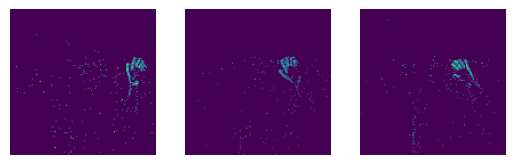

In [3]:
# This is not necessary, but is cool to see
# Converting 1000 event blocks into frames with tonic.transforms.ToFrame
sensor_size = tonic.datasets.DVSGesture.sensor_size
frame_transform = tonic.transforms.ToFrame(sensor_size=sensor_size, event_count=1000)

# Applying the transform to the raw events array
frames = frame_transform(events)

# Shape of the frames object represents (num frames, polarity, width, height)
print(frames.shape)

# Plot some frames
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].imshow(frames[0][0])
ax[1].imshow(frames[10][0])
ax[2].imshow(frames[20][0])

# Transforming the Raw Data

A neural network takes in a tensor as input, so the event array must be transformed into a suitable format.
\
The following code bins events into 1ms groups and denoises each group, or frame. These transforms are then applied to the train and test sets before being passed into dataloaders, which efficiently preprocess the data before passing it into the network.

Shape of frames object:  (25, 2, 128, 128)


  0%|          | 0/691455012 [00:00<?, ?it/s]

Extracting ./data/DVSGesture/ibmGestureTest.tar.gz to ./data/DVSGesture
1077
264


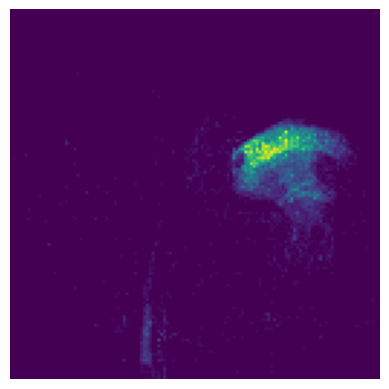

In [4]:
import tonic.transforms as transforms

size = tonic.datasets.DVSGesture.sensor_size

# Denoise transform removes outlier events with inactive surrounding pixels for 10ms
denoise_transform = transforms.Denoise(filter_time=10000)

# ToFrame transform bins events into 1ms blocks
frame_transform = transforms.ToFrame(sensor_size=size, n_time_bins=25)

# Chain the transforms
all_transform = transforms.Compose([denoise_transform, frame_transform])

# View the transformed data
tf_frames = all_transform(events)
print("Shape of frames object: ", tf_frames.shape)
plt.axis('off')
plt.imshow(tf_frames[0][0])

train_set = tonic.datasets.DVSGesture(save_to='./data', transform=all_transform, train=True)
test_set = tonic.datasets.DVSGesture(save_to='./data', transform=all_transform, train=False)
print(len(train_set))
print(len(test_set))

Caching and Dataloaders:
- To optimize and expedite the training process, caching and dataloaders are helpful.
- A dataloader efficiently prepares data for iteration through shuffling, batch size processing, etc.
- Caching the dataset makes iterating through the dataloader much faster, as samples are read from the cache rather than from the disk.

In [5]:
import torch
import torchvision

cached_trainset = tonic.DiskCachedDataset(train_set, cache_path='./cache/dvsgesture/train')
cached_testset = tonic.DiskCachedDataset(test_set, cache_path='./cache/dvsgesture/test')

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(cached_trainset, batch_size=64, shuffle=True, drop_last=True, collate_fn=tonic.collation.PadTensors(batch_first=False))
test_loader = torch.utils.data.DataLoader(cached_testset, batch_size=32, shuffle=True, drop_last=True, collate_fn=tonic.collation.PadTensors(batch_first=False))

# Visualize shape of sample in dataloader (similar to frames object above, but 2nd element is batch size)
for sample in iter(train_loader):
  print("Shape of sample object: ", sample[0].shape)
  break

Shape of sample object:  torch.Size([25, 64, 2, 128, 128])


# Building the Network

The network will be fairly simple; 2 convolution layers with 5 filters each, followed by a fully connected layer.

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import torch.nn as nn

In [8]:
# Network parameters
gradient = surrogate.fast_sigmoid(slope=25)
beta = 0.5

# Initializing the network
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=gradient, init_hidden=True),
                    nn.Conv2d(12, 32, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=gradient, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(800, 11),
                    snn.Leaky(beta=beta, spike_grad=gradient, init_hidden=True, output=True)
                    ).to(device)



**Forward Propagation:**

Since the samples can be interpreted as a short video of 25 frames, a custom forward propagation function helps feed each frame, or cluster of events, into the network one at a time.

- In this case, data.size(0) == 25.

A single forward pass returns a tensor representing the spiking activity from one sample (or batch if batch size > 1).

This should be of size (frame count, batch size, num classes), or (25, 64, 11).

In [9]:
# Defining a forward propagation function
def forward_pass(net, data):
  spk_rec = []
  snn.utils.reset(net)
  for step in range(data.size(0)):
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)
  return torch.stack(spk_rec)

Adam dynamically adjusts the learning rate and is a great general use optimizer for training NNs

In [10]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.002, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

# Training

Note: Dataloading will be slow for the first (num samples/batch size) training steps due to first time loading into the cache

In [11]:
# 50 epochs; counter just used for test set validation
num_epochs = 50
counter = 0

loss_hist = []
acc_hist = []
test_acc_hist = []

# Training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(train_loader)):
        # Downsampling image from (128 x 128) to (32 x 32)
        data = nn.functional.interpolate(data, size=(2, 32, 32))
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        # propagating one batch through the network and evaluating loss
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Train Accuracy: {acc * 100:.2f}%\n")

        # evaluate test set accuracy per 10 training steps
        if counter % 10 == 0:
          correct = 0
          total = 0

          for i, (data, targets) in enumerate(iter(test_loader)):
            data = nn.functional.interpolate(data, size=(2, 32, 32))
            data = data.to(device)
            targets = targets.to(device)
            spk_rec = forward_pass(net, data)
            correct += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
            total += spk_rec.size(1)

          test_acc = (correct/total) * 100
          test_acc_hist.append(test_acc)
          print("========== Test Set Accuracy: ", test_acc, "% ==========")

        counter += 1

Epoch 0, Iteration 0 
Train Loss: 2.36
Train Accuracy: 7.81%

========== Test Set Accuracy:  9.375 % ==========
Epoch 0, Iteration 1 
Train Loss: 2.36
Train Accuracy: 7.81%

Epoch 0, Iteration 2 
Train Loss: 2.32
Train Accuracy: 9.38%

Epoch 0, Iteration 3 
Train Loss: 1.90
Train Accuracy: 10.94%

Epoch 0, Iteration 4 
Train Loss: 1.71
Train Accuracy: 17.19%

Epoch 0, Iteration 5 
Train Loss: 1.42
Train Accuracy: 14.06%

Epoch 0, Iteration 6 
Train Loss: 1.48
Train Accuracy: 20.31%

Epoch 0, Iteration 7 
Train Loss: 1.40
Train Accuracy: 37.50%

Epoch 0, Iteration 8 
Train Loss: 1.45
Train Accuracy: 42.19%

Epoch 0, Iteration 9 
Train Loss: 1.54
Train Accuracy: 23.44%

Epoch 0, Iteration 10 
Train Loss: 1.37
Train Accuracy: 35.94%

========== Test Set Accuracy:  42.1875 % ==========
Epoch 0, Iteration 11 
Train Loss: 1.26
Train Accuracy: 48.44%

Epoch 0, Iteration 12 
Train Loss: 1.27
Train Accuracy: 37.50%

Epoch 0, Iteration 13 
Train Loss: 1.36
Train Accuracy: 46.88%

Epoch 0, Iterat

Plotting the accuracy on the training set, loss, and test set accuracy can help visualize how well the model is performing.
As we can see from the plots below, loss is converging and train/test accuracy is plateauing accordingly.

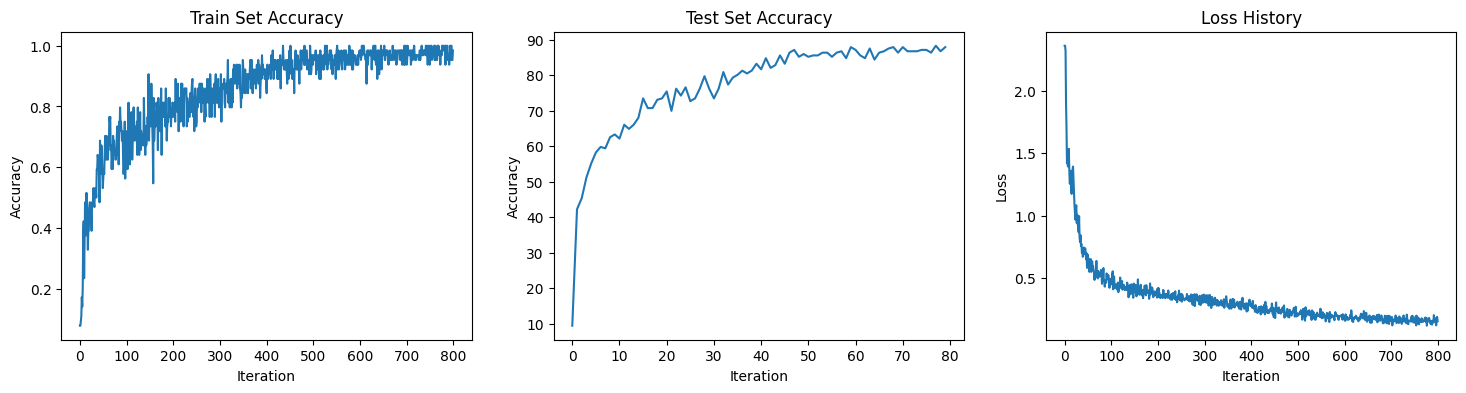

In [12]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(18,4))

# Plot Train Accuracy
axes[0].plot(acc_hist)
axes[0].set_title("Train Set Accuracy")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")

# Plot Test Accuracy
axes[1].plot(test_acc_hist)
axes[1].set_title("Test Set Accuracy")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Accuracy")

# Plot Training Loss
axes[2].plot(loss_hist)
axes[2].set_title("Loss History")
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("Loss")

plt.show()

In [13]:
# Evaluate Test Set Accuracy
correct = 0
total = 0

for i, (data, targets) in enumerate(iter(test_loader)):
  data = nn.functional.interpolate(data, size=(2, 32, 32))
  data = data.to(device)
  targets = targets.to(device)
  spk_rec = forward_pass(net, data)
  correct += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
  total += spk_rec.size(1)

print("Test Set Accuracy: ", (correct/total) * 100, "%")

Test Set Accuracy:  87.890625 %
